In [3]:
from pathlib import Path
import random

random.seed(42)
dataset_path = Path("../mnt/d/SIDD_Medium_Srgb/Data")
pairs = []

scene_folders = [f for f in dataset_path.iterdir() if f.is_dir()]

for scene_folder in scene_folders:
    gt_files = list(scene_folder.glob('*_GT_SRGB_*.PNG')) + list(scene_folder.glob('*_GT_SRGB_*.png'))
    noisy_files = list(scene_folder.glob('*_NOISY_SRGB_*.PNG')) + list(scene_folder.glob('*_NOISY_SRGB_*.png'))
    
    for noisy_file in noisy_files:
        noisy_parts = noisy_file.stem.split('_')
        noisy_number = noisy_parts[-1] if noisy_parts else None
        for gt_file in gt_files:
            gt_parts = gt_file.stem.split('_')
            gt_number = gt_parts[-1] if gt_parts else None
            if noisy_number and gt_number and noisy_number == gt_number:
                pairs.append((noisy_file, gt_file))
                break

print(f"\n✓ Znaleziono {len(pairs)} par obrazów")
random.shuffle(pairs)
n = len(pairs)
train_pairs = pairs[:int(0.7*n)]
val_pairs = pairs[int(0.7*n):int(0.85*n)]
test_pairs = pairs[int(0.85*n):]

print(f"\nPodział danych:")
print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")


✓ Znaleziono 320 par obrazów

Podział danych:
Train: 224, Val: 48, Test: 48


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [ ]:
class DenoisingDataset(Dataset):
    def __init__(self, pairs, transform=None, img_size=256, is_train=False):
        self.pairs = pairs
        self.img_size = img_size
        self.is_train = is_train
        
        if is_train:
            self.transform = transform or transforms.Compose([
                transforms.Resize((img_size + 32, img_size + 32)),
                transforms.RandomCrop(img_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ToTensor()
            ])
        else:
            # Bez augmentacji dla val/test
            self.transform = transform or transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor()
            ])
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        noisy_path, clean_path = self.pairs[idx]
        
        noisy_img = Image.open(noisy_path).convert('RGB')
        clean_img = Image.open(clean_path).convert('RGB')
        
        seed = np.random.randint(2147483647)
        if self.is_train:
            torch.manual_seed(seed)
            noisy_tensor = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_tensor = self.transform(clean_img)
        else:
            noisy_tensor = self.transform(noisy_img)
            clean_tensor = self.transform(clean_img)
        
        return noisy_tensor, clean_tensor


train_dataset = DenoisingDataset(train_pairs, is_train=True)
val_dataset = DenoisingDataset(val_pairs, is_train=False)
test_dataset = DenoisingDataset(test_pairs, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
class UNetDenoiser(nn.Module):
    def __init__(self, dropout_rate=0.05):
        super(UNetDenoiser, self).__init__()
        
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 256x256 -> 128x128
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 128x128 -> 64x64
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 64x64 -> 32x32
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Decoder (upsampling) z skip connections
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 32x32 -> 64x64
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),  # 256 (skip) + 256 (up) = 512 -> 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 64x64 -> 128x128
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),  # 128 (skip) + 128 (up) = 256 -> 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 128x128 -> 256x256
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),  # 64 (skip) + 64 (up) = 128 -> 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Output layer
        self.final = nn.Conv2d(64, 3, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        enc1 = self.enc1(x)
        x = self.pool1(enc1)
        
        enc2 = self.enc2(x)
        x = self.pool2(enc2)
        
        enc3 = self.enc3(x)
        x = self.pool3(enc3)
        
        x = self.bottleneck(x)
        
        x = self.up3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        
        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)
        
        x = self.final(x)
        x = self.sigmoid(x)
        
        return x

model = UNetDenoiser(dropout_rate=0.05).to(device)

In [ ]:
# Setup TensorBoard
from torch.utils.tensorboard import SummaryWriter

log_dir = 'runs/denoising_experiment'
writer = SummaryWriter(log_dir)
print(f"TensorBoard logs saved to: {log_dir}")
print("Uruchom: tensorboard --logdir=runs")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

early_stopping = EarlyStopping(patience=5, min_delta=0.0001)

def train_epoch(model, loader, criterion, optimizer, epoch, writer):
    model.train()
    total_loss = 0
    for batch_idx, (noisy, clean) in enumerate(loader):
        noisy, clean = noisy.to(device), clean.to(device)
        
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 5 == 0:
            global_step = epoch * len(loader) + batch_idx
            writer.add_scalar('Train/BatchLoss', loss.item(), global_step)
            writer.add_scalar('Train/LearningRate', optimizer.param_groups[0]['lr'], global_step)
    
    avg_loss = total_loss / len(loader)
    writer.add_scalar('Train/EpochLoss', avg_loss, epoch)
    return avg_loss

def validate(model, loader, criterion, epoch, writer):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            loss = criterion(output, clean)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    writer.add_scalar('Validation/EpochLoss', avg_loss, epoch)
    return avg_loss
num_epochs = 20
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, epoch, writer)
    val_loss = validate(model, val_loader, criterion, epoch, writer)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Zapisz najlepszy model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    # Early stopping
    if early_stopping(val_loss):
        print(f"\nEarly stopping at epoch {epoch+1}")
        model.load_state_dict(best_model_state)
        break
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

model.load_state_dict(best_model_state)
writer.close()

# Zapisz model
model_path = 'denoising_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_class': 'ConvAutoencoder',
    'dropout_rate': 0.1,
    'img_size': 256
}, model_path)
print(f"\nModel zapisany do: {model_path}")

TensorBoard logs saved to: runs/denoising_experiment
Uruchom: tensorboard --logdir=runs
Epoch 1/20 - Train Loss: 0.022350, Val Loss: 0.037646, LR: 0.001000
Epoch 2/20 - Train Loss: 0.006245, Val Loss: 0.003483, LR: 0.001000
Epoch 3/20 - Train Loss: 0.005428, Val Loss: 0.001528, LR: 0.001000
Epoch 4/20 - Train Loss: 0.005207, Val Loss: 0.001142, LR: 0.001000
Epoch 5/20 - Train Loss: 0.007072, Val Loss: 0.001186, LR: 0.001000
Epoch 6/20 - Train Loss: 0.004435, Val Loss: 0.001183, LR: 0.001000
Epoch 7/20 - Train Loss: 0.003050, Val Loss: 0.001065, LR: 0.001000
Epoch 8/20 - Train Loss: 0.003366, Val Loss: 0.000645, LR: 0.001000
Epoch 9/20 - Train Loss: 0.003346, Val Loss: 0.002296, LR: 0.001000
Epoch 10/20 - Train Loss: 0.004642, Val Loss: 0.000826, LR: 0.001000
Epoch 11/20 - Train Loss: 0.003418, Val Loss: 0.000634, LR: 0.001000
Epoch 12/20 - Train Loss: 0.005156, Val Loss: 0.000691, LR: 0.001000

Early stopping at epoch 13

Model zapisany do: denoising_model.pth


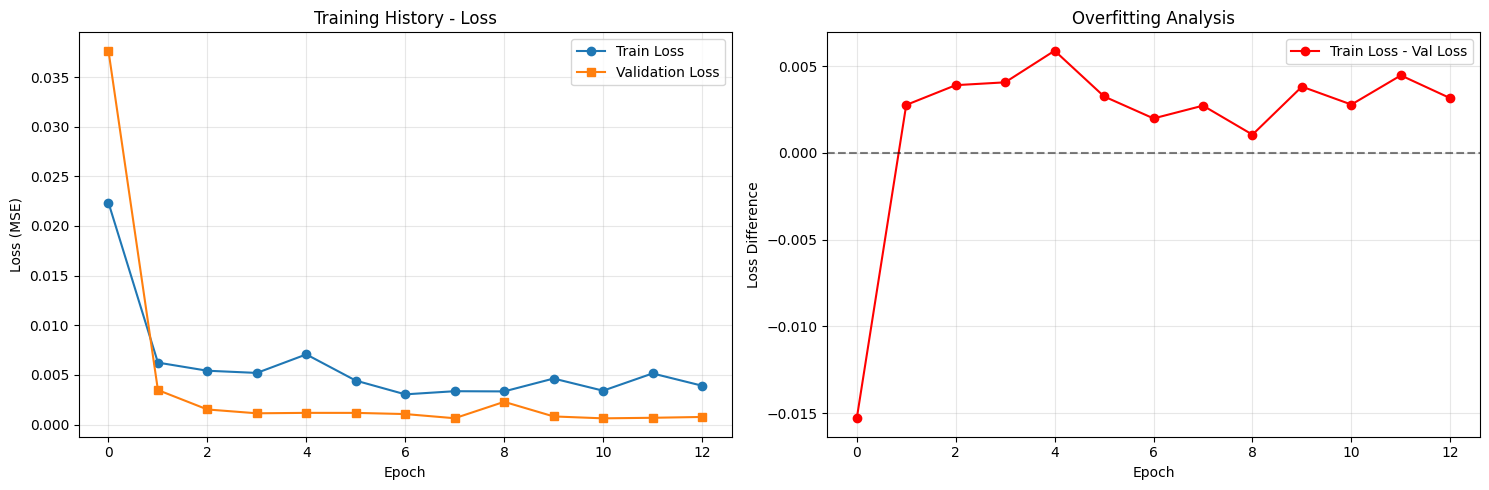

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training History - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

overfitting_gap = [t - v for t, v in zip(train_losses, val_losses)]
axes[1].plot(overfitting_gap, label='Train Loss - Val Loss', marker='o', color='red')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Difference')
axes[1].set_title('Overfitting Analysis')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
from skimage.metrics import peak_signal_noise_ratio as psnr

try:
    from skimage.metrics import structural_similarity_index as ssim
except ImportError:
    from skimage.metrics import structural_similarity as ssim

def calculate_metrics(pred, target):
    """Oblicza PSNR i SSIM dla batcha obrazów"""
    batch_psnr = []
    batch_ssim = []
    
    for i in range(pred.shape[0]):
        # Konwertuj z tensor do numpy
        pred_np = pred[i].cpu().permute(1, 2, 0).numpy()
        target_np = target[i].cpu().permute(1, 2, 0).numpy()
        
        # Ogranicz do [0,1]
        pred_np = np.clip(pred_np, 0, 1)
        target_np = np.clip(target_np, 0, 1)
        
        # PSNR
        psnr_val = psnr(target_np, pred_np, data_range=1.0)
        batch_psnr.append(psnr_val)
        
        # SSIM - kompatybilność z różnymi wersjami scikit-image
        try:
            # Nowa wersja (scikit-image >= 0.19)
            ssim_val = ssim(target_np, pred_np, data_range=1.0, channel_axis=2, win_size=7)
        except TypeError:
            # Stara wersja (scikit-image < 0.19)
            ssim_val = ssim(target_np, pred_np, data_range=1.0, multichannel=True, win_size=7)
        batch_ssim.append(ssim_val)
    
    return np.mean(batch_psnr), np.mean(batch_ssim)

# Ewaluacja na zbiorze testowym
model.eval()
test_losses = []
test_psnrs = []
test_ssims = []

with torch.no_grad():
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        
        loss = criterion(output, clean)
        test_losses.append(loss.item())
        
        psnr_val, ssim_val = calculate_metrics(output, clean)
        test_psnrs.append(psnr_val)
        test_ssims.append(ssim_val)

avg_test_loss = np.mean(test_losses)
avg_test_psnr = np.mean(test_psnrs)
avg_test_ssim = np.mean(test_ssims)

print("\n" + "="*60)
print("EWALUACJA MODELU NA ZBIORZE TESTOWYM")
print("="*60)
print(f"MSE Loss: {avg_test_loss:.6f}")
print(f"PSNR: {avg_test_psnr:.2f} dB")
print(f"SSIM: {avg_test_ssim:.4f}")
print("="*60)



EWALUACJA MODELU NA ZBIORZE TESTOWYM
MSE Loss: 0.000876
PSNR: 32.83 dB
SSIM: 0.9466


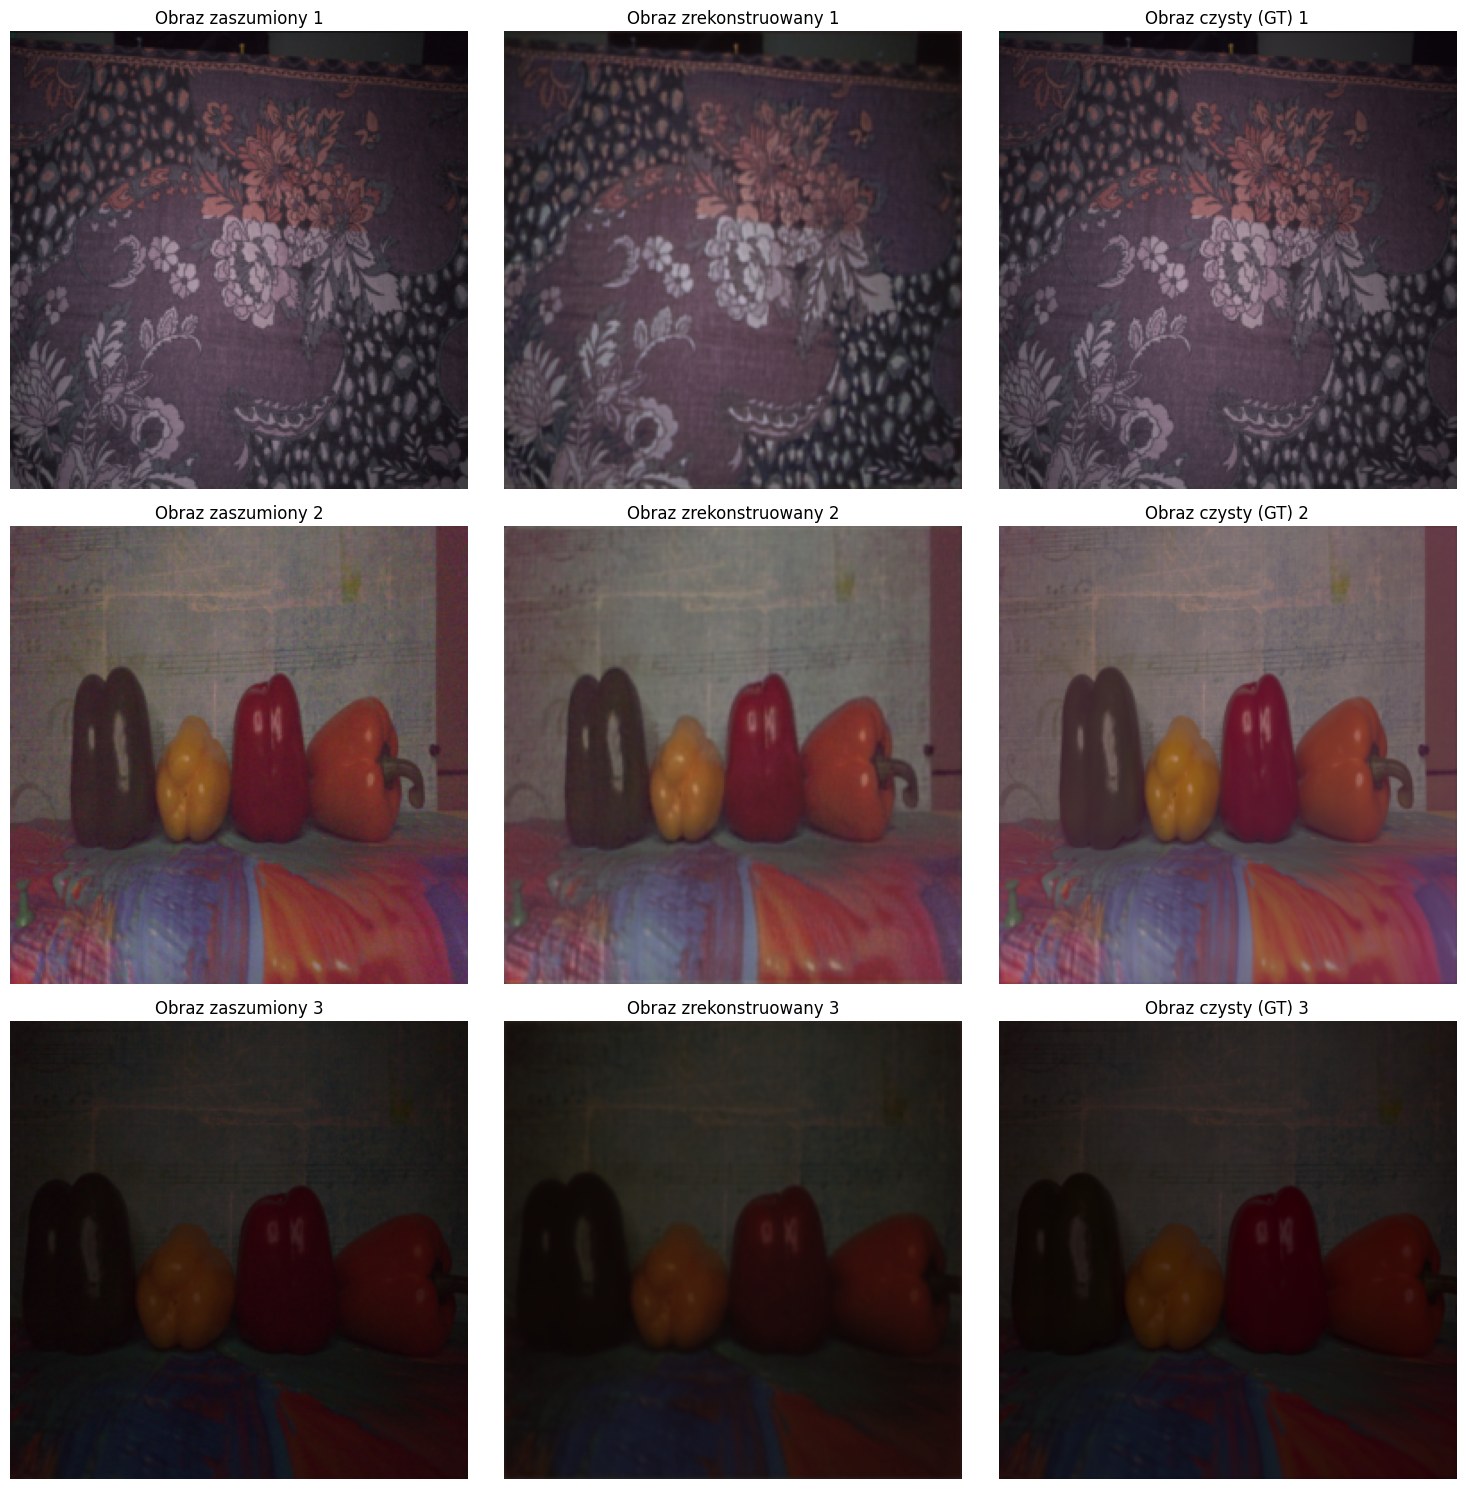

In [ ]:
model.eval()
with torch.no_grad():
    noisy, clean = next(iter(test_loader))
    noisy, clean = noisy.to(device), clean.to(device)
    output = model(noisy)
    n_images = min(3, output.shape[0])
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        noisy_np = noisy[i].cpu().permute(1, 2, 0).numpy()
        output_np = output[i].cpu().permute(1, 2, 0).numpy()
        clean_np = clean[i].cpu().permute(1, 2, 0).numpy()
        
        noisy_np = np.clip(noisy_np, 0, 1)
        output_np = np.clip(output_np, 0, 1)
        clean_np = np.clip(clean_np, 0, 1)
        
        axes[i, 0].imshow(noisy_np, vmin=0, vmax=1)
        axes[i, 0].set_title(f'Obraz zaszumiony {i+1}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(output_np, vmin=0, vmax=1)
        axes[i, 1].set_title(f'Obraz zrekonstruowany {i+1}')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(clean_np, vmin=0, vmax=1)
        axes[i, 2].set_title(f'Obraz czysty (GT) {i+1}')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*60)
print("ZASTOSOWANE METODY ZAPOBIEGANIA OVERFITTINGOWI")
print("="*60)
print("\n1. DATA AUGMENTATION:")
print("   - RandomCrop: losowe przycinanie obrazów")
print("   - RandomHorizontalFlip: losowe odbicie poziome (p=0.5)")
print("   - RandomVerticalFlip: losowe odbicie pionowe (p=0.5)")
print("   - Zwiększa różnorodność danych treningowych")
print("\n2. DROPOUT:")
print("   - Dropout2d (rate=0.1) TYLKO w encoderze")
print("   - Losowe wyłączanie 10% neuronów podczas treningu w encoderze")
print("   - Brak dropout w decoderze - zachowuje szczegóły podczas rekonstrukcji")
print("   - Zapobiega zapamiętywaniu specyficznych cech")
print("\n2b. BATCH NORMALIZATION:")
print("   - BatchNorm2d w każdej warstwie konwolucyjnej")
print("   - Stabilizuje trening i przyspiesza konwergencję")
print("   - Pomaga w generalizacji modelu")
print("\n4. EARLY STOPPING:")
print("   - Patience: 5 epok")
print("   - Zatrzymuje trening gdy val loss przestaje się poprawiać")
print("   - Zapobiega przeuczeniu modelu")
print("\n6. PODZIAŁ DANYCH:")
print("   - 70% train, 15% validation, 15% test")
print("   - Walidacja w każdej epoce")
print("   - Monitoring różnicy między train a val loss")
print("="*60)


ZASTOSOWANE METODY ZAPOBIEGANIA OVERFITTINGOWI

1. DATA AUGMENTATION:
   - RandomCrop: losowe przycinanie obrazów
   - RandomHorizontalFlip: losowe odbicie poziome (p=0.5)
   - RandomVerticalFlip: losowe odbicie pionowe (p=0.5)
   - Zwiększa różnorodność danych treningowych

2. DROPOUT:
   - Dropout2d (rate=0.1) TYLKO w encoderze
   - Losowe wyłączanie 10% neuronów podczas treningu w encoderze
   - Brak dropout w decoderze - zachowuje szczegóły podczas rekonstrukcji
   - Zapobiega zapamiętywaniu specyficznych cech

2b. BATCH NORMALIZATION:
   - BatchNorm2d w każdej warstwie konwolucyjnej
   - Stabilizuje trening i przyspiesza konwergencję
   - Pomaga w generalizacji modelu

3. ARCHITEKTURA:
   - ConvTranspose2d zamiast Upsample (lepsza rekonstrukcja szczegółów)
   - Encoder: kompresja z MaxPool2d
   - Decoder: dekompresja z ConvTranspose2d

4. EARLY STOPPING:
   - Patience: 5 epok
   - Zatrzymuje trening gdy val loss przestaje się poprawiać
   - Zapobiega przeuczeniu modelu

5. LEARNI